In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('project_data5.csv')
data

,발생원인,월별,시간대별,사고규모,풍속(m/s),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),최대파고(m),...,선 종_기타(통선),선 종_낚시어선,선 종_모터보트,선 종_어선,선 종_여객선,선 종_예부선,선 종_요트,선 종_유도선,선 종_유조선,선 종_화물선
0,운항과실,12,6,2.659574,4.9,7.5,1027.9,51.0,4.8,1.1,...,0,1,0,0,0,0,0,0,0,0
1,취급불량 및 결함,12,21,0.030538,2.7,4.9,1028.6,58.0,8.6,2.2,...,0,0,0,1,0,0,0,0,0,0
2,취급불량 및 결함,12,11,0.333333,6.7,9.6,1030.0,51.0,5.1,2.8,...,0,0,0,1,0,0,0,0,0,0
3,운항과실,12,14,0.186235,8.8,11.8,1028.4,64.0,4.7,2.5,...,0,0,0,0,1,0,0,0,0,0
4,관리문제,12,13,0.238095,8.8,11.5,1029.4,63.0,4.8,3.1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16842,취급불량 및 결함,1,17,2.333333,7.0,9.7,1023.9,56.0,5.0,2.3,...,0,1,0,0,0,0,0,0,0,0
16843,취급불량 및 결함,1,15,0.518135,6.3,8.9,1023.9,55.0,4.4,3.0,...,0,0,0,1,0,0,0,0,0,0
16844,취급불량 및 결함,1,12,2.311248,8.0,10.3,1027.0,62.0,3.0,1.3,...,0,1,0,0,0,0,0,0,0,0
16845,운항과실,1,11,0.500000,6.5,9.6,1027.9,59.0,4.5,1.7,...,0,0,0,1,0,0,0,0,0,0


# Light GBM

- LightGBM은 트리 기준 분할이 아닌 리프 기준 분할 방식을 사용한다. 
- 트리의 균형을 맞추지 않고 최대 손실 값을 갖는 리프 노드를 지속적으로 분할하면서 깊고 비대칭적인 트리를 생성한다. 
- 기존 트리 기준 분할 방식에 비해 예측 오류 손실을 최소화할 수 있다.

In [3]:
import lightgbm as lgb

In [4]:
y = data['발생원인']
X = data.drop(['발생원인'], axis=1)

In [5]:
y_dum=pd.get_dummies(y)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train , x_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,stratify=y_train,test_size=0.2,random_state=0)

- num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수
- learning_rate : 부스팅스탭 반복할 때 학습률

In [8]:
from sklearn.metrics import accuracy_score
training_accuracy = []
val_accuracy = []
learn_rate=[0.1,0.01,0.001,0.003]
num_leaf=[20,25,30,40]

for j in learn_rate:
    for n in num_leaf:
        lgb_clf = lgb.LGBMClassifier(learning_rate=j,objective='multiclass',num_leaves=n)
        lgb_clf.fit(x_train,y_train)
        y_train_pred = lgb_clf.predict(x_train)
        y_pred = lgb_clf.predict(x_val)
        training_accuracy.append(accuracy_score(y_train,y_train_pred))
        val_accuracy.append(accuracy_score(y_val,y_pred))

In [9]:
pd.DataFrame({"learning_rate":sorted(learn_rate*4), "num_leaf":sorted(num_leaf*4), "training accuracy": training_accuracy, "validation accuracy": val_accuracy})

,learning_rate,num_leaf,training accuracy,validation accuracy
0,0.001,20,0.724515,0.531899
1,0.001,20,0.765421,0.537463
2,0.001,20,0.801595,0.540430
3,0.001,20,0.864948,0.541172
4,0.003,25,0.568871,0.532270
5,0.003,25,0.578425,0.536721
6,0.003,25,0.587979,0.534125
7,0.003,25,0.607550,0.534496
8,0.010,30,0.418700,0.418769
9,0.010,30,0.419349,0.419510


In [10]:
final_lgb_clf = lgb.LGBMClassifier(learning_rate=0.003,objective='multiclass',num_leaves=25)
final_lgb_clf.fit(x_train,y_train)
y_pred = final_lgb_clf.predict(x_test)

In [11]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [12]:
accuracy_score(y_pred, y_test)

0.45252225519287836

In [13]:
f1_score(y_pred, y_test, average='macro')

0.19253376833226427

In [14]:
confusion_matrix(y_test, y_pred)

array([[  19,    0,    0,   30,  394],
       [   0,    0,    0,    9,  130],
       [   3,    0,    0,   44,  179],
       [   3,    0,    0,  232,  917],
       [   1,    0,    0,  135, 1274]], dtype=int64)

In [15]:
feature_importance = pd.DataFrame(final_lgb_clf.feature_importances_.reshape((1, -1)), columns=x_train.columns, index=['feature_importance'])
feature_importance

,월별,시간대별,사고규모,풍속(m/s),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),최대파고(m),파주기(sec),...,선 종_기타(통선),선 종_낚시어선,선 종_모터보트,선 종_어선,선 종_여객선,선 종_예부선,선 종_요트,선 종_유도선,선 종_유조선,선 종_화물선
feature_importance,559,951,2236,543,736,671,341,607,371,585,...,0,54,479,290,0,127,0,0,3,91


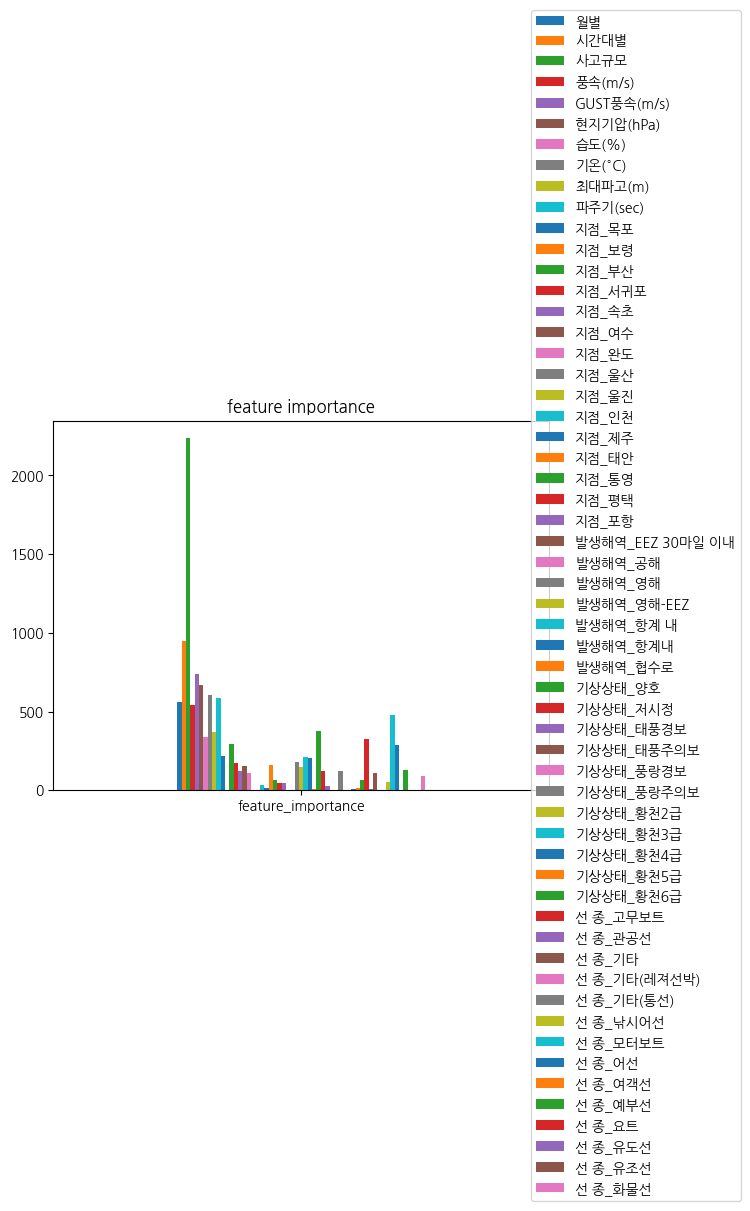

In [22]:
import matplotlib.pyplot as plt
feature_importance.plot(kind = 'bar', rot = 0)
plt.title("feature importance")
plt.legend(loc='center right',bbox_to_anchor=(1.4, 0.5))
plt.show()

### lightgbm
- kaggle에서도 많이 쓰였고 실제로 우승도 많이 했던 xgboost보다 더 낫다고 알려져 있어서 randomforest보다 더 나은 성능이 나올 것이라고 예측 했으나 전혀 못 미치고 있음을 확인함.
- 특히 f1-score는 19.3%정도로 SVM보다 낮음을 확인함 -> confusion_matrix에서 '기상문제'와 '기타'로 예측한 class가 하나도 없기 때문
- 각 알고리즘 마다 예측 성능이 다른 것은 class를 예측할 때 있어 어떤 class로는 덜 예측하는 경향이 있는데 이것이 성능에 직결됨.
- accuracy : 45.3%, f1_score : 19.3%